In [2]:
import jax
import jax_metrics as jm
import jax.numpy as jnp
from jax import grad, jit, vmap
from functools import partial
from jax import random
import os
import numpy as np
import matplotlib.pyplot as plt
# Switch off the cache 
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
os.environ['XLA_PYTHON_CLIENT_ALLOCATOR'] = 'platform'

# Basic Linear Model

Class for Linear estimation with Canonical and Gradient Descent

In [6]:
class Linear_Model():
    """
    Basic Linear Regression with Ridge Regression
    """
    def __init__(self, dim: int) -> None:
        self.dim = dim
        self.key = random.PRNGKey(0)
        self.cpus = jax.devices("cpu")
    
    # The classic one
    @staticmethod
    def generate_canonical_estimator(X: jnp, y:jnp) -> jnp:
        """
        Cannonical LSE error solution for the Linearly separable classes 
        args:
            X: Data array at the GPU or CPU
            y: Label array at the GPU 
        returns:
            w: Weight array at the GPU or CPU
        """
        return  jax.numpy.linalg.inv(jax.numpy.transpose(X)@X)@jax.numpy.transpose(X)@y
    
    @staticmethod
    @jit
    def linear_model(X: jnp, theta: jnp) -> jnp:
        """
        Classic Linear Model. Jit has been used to accelerate the loops after the first one
        for the Gradient Descent part
        args:
            X: Data array at the GPU or CPU
            theta: Parameter w for weights and b for bias
        returns:
            f(x): the escalar estimation on vector x or the array of estimations
        """
        w = theta[:-1]
        b = theta[-1]
        return jax.numpy.matmul(X, w) + b
    
    @partial(jit, static_argnums=(0,))
    def LSE(self, theta: jnp, X: jnp, y: jnp)-> jnp:
        """
        LSE in matrix form. We also use Jit por froze info at self to follow 
        the idea of functional programming on Jit for no side effects
        args:
            X: Data array at the GPU or CPU
            theta: Parameter w for weights and b for bias
            y: array of labels
        returns:
            the Loss function LSE under data X, labels y and theta initial estimation
        """
        return (jax.numpy.transpose(y - self.linear_model(X, theta))@(y - self.linear_model(X, theta)))[0,0]
    
    @partial(jit, static_argnums=(0,))
    def update(self, theta: jnp, X: jnp, y: jnp, lr: float)->jnp:
        """
        Update makes use of the autograd at Jax to calculate the gradient descent.
        args:
            X: Data array at the GPU or CPU
            theta: Parameter w for weights and b for bias
            y: array of labels
            lr: Learning rate for Gradient Descent
        returns:
            the step update w(n+1) = w(n)-δ(t)𝜵L(w(n))        
        """
        return theta - lr * jax.grad(self.LSE)(theta, X, y)  

    def generate_w_aug(self)->jnp:
        """
        Use the random generator at Jax to generate a random generator to instanciate
        the augmented values
        """
        keys = random.split(self.key, 1)
        return jax.numpy.vstack([random.normal(keys, (self.dim,1)), jax.numpy.array(1)])
    
    def generate_theta(self)->jnp:
        """
        Use the random generator at Jax to generate a random generator to instanciate
        the augmented values
        """
        keys = random.split(self.key, 1)
        return jax.numpy.vstack([random.normal(keys, (self.dim,1)), jax.numpy.array(0)])
    
    @partial(jit, static_argnums=(0,))
    def estimate_grsl(self, X: jnp, theta: jnp)->jnp:
        """
        Estimation for the Gradient Descent version
        args:
            X: Data array at the GPU or CPU
            theta: Parameter w for weights and b for bias
        return:
            Estimation of data X under linear model
        """
        w = theta[:-1]
        b = theta[-1]
        return X@w+b
    
    @staticmethod
    def estimate_cannonical(X: jnp, w: jnp)->jnp:
        """
        Estimation for the Gradient Descent version
        args:
            X: Data array at the GPU or CPU
            w: Parameter w under extended space
        return:
            Estimation of data X under cannonical solution
        """
        return X@w
    
    def precision(self, y: jnp, y_hat: jnp)->float:
        """
        Precision
        args:
            y: Real Labels
            y_hat: estimated labels
        return TP/(TP+FP)
        """
        TP = sum(y_hat[y>0]>0)
        FP = sum(y_hat[y>0]<0)
        result = TP/(TP+FP)
        precision_cpu = jax.jit(lambda x: x, device=self.cpus[0])(result)
        return float(precision_cpu)
    
    def gradient_descent(self, theta: jnp,  X: jnp, y: jnp, n_steps: int, lr = 0.001)->jnp:
        """
        Gradient Descent Loop for the LSE Linear Model
        args:
            X: Data array at the GPU or CPU
            theta: Parameter w for weights and b for bias
            y: array of labels
            n_steps: number steps for the Gradient Loop
            lr: Learning rate for Gradient Descent   
        return:
            Updated Theta
        """
        for i in range(n_steps):
            theta = self.update(theta, X, y, lr)
        return theta
    
    def gradient_descent_armijo(self, theta: jnp,  X: jnp, y: jnp)->jnp:
        """
        """
        Grad = jax.grad(self.LSE)(theta, X, y)
        p = -Grad
        m = jnp.dot(jnp.transpose(Grad), p)[0,0]
        c = 0.000001
        tau = 0.8
        t = -c*m
        alpha = 1
        while True:
            f_x = self.LSE(theta, X, y)
            while f_x - self.LSE(theta + alpha*p, X, y)  < alpha*t:
                alpha = tau*alpha
            theta = self.update(theta, X, y, alpha)
            pGrad = Grad
            Grad = jax.grad(self.LSE)(theta, X, y)
            if not jnp.linalg.norm(Grad) < jnp.linalg.norm(pGrad):
                break
            p = -Grad
            m = jnp.dot(jnp.transpose(Grad), p)[0,0]
            t = -c*m
            alpha = 1
            # print(jnp.linalg.norm(Grad))
        return theta
            

         

# Generate Data

In [22]:
X1 = np.random.normal(size=(100,2))
X2 = np.random.normal(size=(100,2))+(5,5)

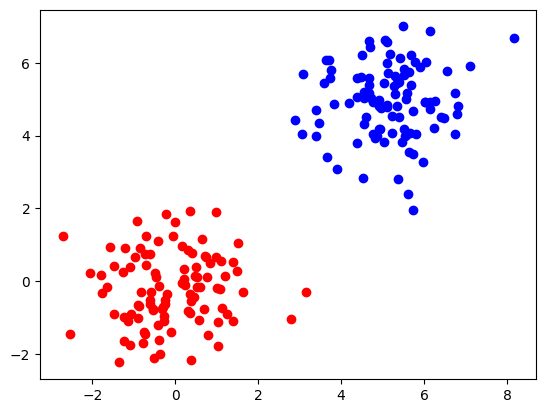

In [23]:
plt.figure()
plt.plot(X1[:,0], X1[:,1], 'ro')
plt.plot(X2[:,0], X2[:,1], 'bo')

# Expriments
Data Augmentation is applied for the Cannonical version

In [24]:
X1_e = np.hstack([X1, np.ones((100,1))])
X2_e = np.hstack([X2, np.ones((100,1))])

In [25]:
X_e = np.vstack([X1_e, X2_e])
X = np.vstack([X1, X2])

In [26]:
y = np.vstack([-np.ones((100, 1)), np.ones((100, 1))])

In [27]:
model = Linear_Model(2)

In [28]:
w = model.generate_canonical_estimator(X_e, y)

In [29]:
y_hat = model.estimate_cannonical(X_e, w)

In [30]:
w

Array([[ 0.18071659],
       [ 0.17697832],
       [-0.8717973 ]], dtype=float32)

In [31]:
model.precision(y, y_hat)

1.0

In [32]:
theta = model.generate_theta()

In [33]:
theta = model.gradient_descent_armijo(theta, X, y)

15390.81
12085.381
9489.938
7451.9966
5851.823
4595.406
3608.9258
2834.421
2226.38
1749.07
1374.4373
1080.4568
849.8399
669.0165
527.33685
416.4449
329.78534
262.21524
209.69742


In [34]:
y_hat = model.estimate_grsl(X, theta)

In [35]:
model.precision(y, y_hat)

1.0

In [36]:
theta

Array([[ 0.16002521],
       [ 0.17315716],
       [-0.56790805]], dtype=float32)